<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/pytorch/UNet_Seg_VOC2012_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNet, VOC Segmentation 2012

元論文 : U-Net https://arxiv.org/abs/1505.04597 (2015)



In [22]:
!pip install numpy matplotlib opencv-python torch torchvision torchsummary pandas easydict

## Import and Config

In [42]:
import os
import argparse
from pprint import pprint
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from easydict import EasyDict

import torch
import torch.nn.functional as F
import torchvision
from torchsummary import summary
from torchvision import transforms


#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
            'dinigtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'void'] # list, dict('label' : '[R, G, B]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_HEIGHT = 128
cfg.INPUT_WIDTH = 128
cfg.INPUT_CHANNEL = 3
cfg.INPUT_CMAP = 'gray'

cfg.OUTPUT_HEIGHT = 128
cfg.OUTPUT_WIDTH = 128
cfg.OUTPUT_CHANNEL = cfg.CLASS_NUM
cfg.OUTPUT_CMAP = 'jet' # pyplot cmap

cfg.G_DIM = 32

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = True
cfg.DEVICE_TYPE = 'cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu'
cfg.DEVICE = torch.device(cfg.DEVICE_TYPE)

# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'UNet'
cfg.TRAIN.MODEL_SAVE_PATH = 'models/' + cfg.PREFIX + '_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 200
cfg.TRAIN.ITERATION = 3_000
cfg.TRAIN.MINIBATCH = 32
cfg.TRAIN.OPTIMIZER = torch.optim.SGD
cfg.TRAIN.LEARNING_PARAMS = {'lr' : 0.01, 'momentum' : 0.9}#{'lr' : 0.01, 'betas' : (0.5, 0.9)}


cfg.TRAIN.DATA_PATH = 'data/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = True # data augmentation : holizontal flip
cfg.TRAIN.DATA_VERTICAL_FLIP = True # data augmentation : vertical flip
cfg.TRAIN.DATA_ROTATION = 1 # data augmentation : rotation False, or integer

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 200
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.txt'

#---
# pix2pix  config
#---
cfg.PIX2PIX_LAMBDA = 1


# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_PATH = cfg.TRAIN.MODEL_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = 'data/'
cfg.TEST.MINIBATCH = 10
cfg.TEST.MAX_SAMPLES = 100 # None, int
cfg.TEST.ITERATION = 2
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)

pprint(cfg)

{'CHANNEL_AXIS': 1,
 'CLASS_LABEL': ['background',
                 'aeroplane',
                 'bicycle',
                 'bird',
                 'boat',
                 'bottle',
                 'bus',
                 'car',
                 'cat',
                 'chair',
                 'cow',
                 'dinigtable',
                 'dog',
                 'horse',
                 'motorbike',
                 'person',
                 'pottedplant',
                 'sheep',
                 'sofa',
                 'train',
                 'tvmonitor',
                 'void'],
 'CLASS_NUM': 22,
 'DEVICE': device(type='cuda'),
 'DEVICE_TYPE': 'cuda',
 'GPU': True,
 'G_DIM': 32,
 'INPUT_CHANNEL': 3,
 'INPUT_CMAP': 'gray',
 'INPUT_HEIGHT': 128,
 'INPUT_WIDTH': 128,
 'OUTPUT_CHANNEL': 22,
 'OUTPUT_CMAP': 'jet',
 'OUTPUT_HEIGHT': 128,
 'OUTPUT_WIDTH': 128,
 'PIX2PIX_LAMBDA': 1,
 'PREFIX': 'UNet',
 'TEST': {'DATA_PATH': 'data/',
          'ITERATION': 2,
          

## Define Model

In [0]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.reshape(x.size()[0], -1)

    
class Encoder_block(torch.nn.Module):
    def __init__(self, dim1, dim2, name, stack_num=2):
        super(Encoder_block, self).__init__()
        _module = OrderedDict()
        for i in range(stack_num):
            f = dim1 if i == 0 else dim2
            _module['{}_stack_{}_conv'.format(name, i  + 1)] = torch.nn.Conv2d(f, dim2, kernel_size=3, padding=1, stride=1)
            _module['{}_stack_{}_act'.format(name, i + 1)] = torch.nn.ReLU()
            _module['{}_stack_{}_bn'.format(name, i + 1)] = torch.nn.BatchNorm2d(dim2)
            
        self.module = torch.nn.Sequential(_module)

    def forward(self, x):
        return self.module(x)

class Decoder_block(torch.nn.Module):
    def __init__(self, dim1, dim2, name):
        super(Decoder_block, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            '{}_transConv'.format(name) : torch.nn.ConvTranspose2d(dim1, dim2, kernel_size=2, stride=2),
            '{}_bn'.format(name) : torch.nn.BatchNorm2d(dim2)
        }))

    def forward(self, x):
        return self.module(x)

    
class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        dim = cfg.G_DIM
        
        self.encoders = torch.nn.ModuleList([
            Encoder_block(cfg.INPUT_CHANNEL, dim, name='encoder_1'), 
            Encoder_block(dim, dim * 2, name='encoder_2'),
            Encoder_block(dim * 2, dim * 4, name='encoder_3'),
            Encoder_block(dim * 4, dim * 8, name='encoder_4'),
            Encoder_block(dim * 8, dim * 16, name='encoder_5'),
            #Encoder_block(dim * 16, dim * 16, name='G_encoder_6'),
        ])
        
        self.decoders = torch.nn.ModuleList([
            #Encoder_block(dim * 16, dim * 16, name='G_decoder_5'),
            Encoder_block(dim * 16, dim * 8, name='decoder_4'),
            Encoder_block(dim * 16, dim * 4, name='decoder_3'),
            Encoder_block(dim * 8, dim * 2, name='decoder_2'),
            Encoder_block(dim * 4, dim, name='decoder_1'),
        ])
            
        self.out = torch.nn.Sequential(OrderedDict({
            'G_out' : torch.nn.Conv2d(dim, cfg.OUTPUT_CHANNEL, kernel_size=1, padding=0, stride=1),
            #'G_out_act' : torch.nn.Softmax(dim=1)
        }))

        
    def forward(self, x):
        outputs = []
        # encoder
        for encoder in self.encoders[:-1]:
            x = encoder(x)
            outputs.append(x)
            x = F.max_pool2d(x, 2, stride=2, padding=0)
        
        x = self.encoders[-1](x)
        
        # decoder
        for i, decoder in enumerate(self.decoders[:-1]):
            x = decoder(x)
            x = F.interpolate(x, scale_factor=2, mode='nearest')
            x = torch.cat([x, outputs[ - i - 1]], dim=1)
        
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.decoders[-1](x)
        return self.out(x)


## Utility

In [0]:
class BatchGenerator():
    def __init__(self, data_size, batch_size, shuffle=True):
        self.data_size = data_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.mbi = 0 # index for iteration
        self.inds = np.arange(data_size)
        if shuffle:
            np.random.shuffle(self.inds)

    def __call__(self):
        if self.mbi + self.batch_size >= self.data_size:
            inds = self.inds[self.mbi:]
            if self.shuffle:
                np.random.shuffle(self.inds)
            else:
                last_i = self.batch_size - self.data_size + self.mbi
                inds = np.hstack((inds, self.inds[ : last_i]))
                self.mbi = last_i
        else:
            inds = self.inds[self.mbi : self.mbi + self.batch_size]
            self.mbi += self.batch_size
        return inds

def result_show(Xs, ys, ts, path=None, save=False, show=False,  figsize=(12, 4), cmap_in=None, cmap_out=None):
    Xs = (Xs.detach().cpu().numpy() * 255).astype(np.uint8).transpose(0, 2, 3, 1)
    ys = ys.detach().cpu().numpy().astype(np.uint8)
    ts = ts.detach().cpu().numpy().astype(np.uint8)

    show_max = min(cfg.TEST.MINIBATCH, len(Xs))
    
    plt.figure(figsize=figsize)
        
    for i in range(show_max):
        # show input
        plt.subplot(3, show_max, i + 1)
        plt.imshow(Xs[i], cmap=cmap_in)
        plt.axis('off')
        plt.title('In {}'.format(i + 1))
        
        # show output
        plt.subplot(3, show_max, i + 1 + show_max)
        plt.imshow(ys[i], cmap=cmap_out, vmax=cfg.CLASS_NUM)
        plt.axis('off')
        plt.title('pred {}'.format(i + 1))

        # show ts
        plt.subplot(3, show_max, i + 1 + show_max * 2)
        plt.imshow(ts[i], cmap=cmap_out, vmax=cfg.CLASS_NUM)
        plt.axis('off')
        plt.title('ts {}'.format(i + 1))

    plt.tight_layout()
    
    if save:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()
    else:
        plt.close()

#---
# torchvision dataset transform
#---
from PIL import Image

class Seg2Index(object):
    def __init__(self, border=False):
        self.border = border # contain border

    def __call__(self, x):
        x = np.array(x.convert('P')) # convert image > index
        if not self.border:
            x[x == 255] = 0
        return Image.fromarray(x)

    def __repr__(self):
        return self.__class__.__name__ + '()'

class ToTensorKeepValue(object):
    def __call__(self, x):
        return torch.tensor(np.array(x), dtype=torch.long)

    def __repr__(self):
        return self.__class__.__name__ + '()'


transform = transforms.Compose([
    transforms.Resize((cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH)),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    Seg2Index(),
    transforms.Resize((cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH)),
    ToTensorKeepValue()
])

## Train

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
       BatchNorm2d-3         [-1, 32, 128, 128]              64
            Conv2d-4         [-1, 32, 128, 128]           9,248
              ReLU-5         [-1, 32, 128, 128]               0
       BatchNorm2d-6         [-1, 32, 128, 128]              64
     Encoder_block-7         [-1, 32, 128, 128]               0
            Conv2d-8           [-1, 64, 64, 64]          18,496
              ReLU-9           [-1, 64, 64, 64]               0
      BatchNorm2d-10           [-1, 64, 64, 64]             128
           Conv2d-11           [-1, 64, 64, 64]          36,928
             ReLU-12           [-1, 64, 64, 64]               0
      BatchNorm2d-13           [-1, 64, 64, 64]             128
    Encoder_block-14           [-1, 64,

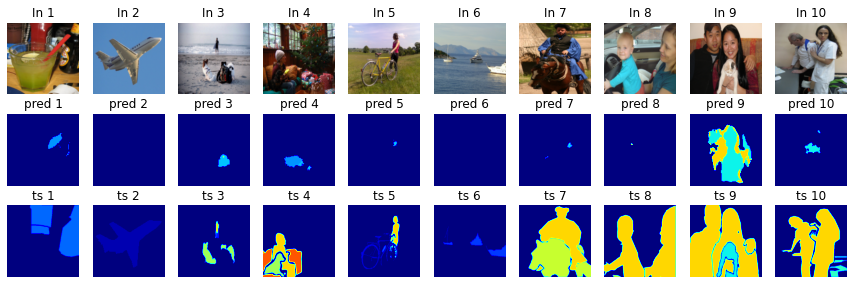

Iter:250, Loss:1.0838, Accuracy:0.5458
Iter:300, Loss:1.3839, Accuracy:0.4917
Iter:350, Loss:0.9888, Accuracy:0.5733
Iter:400, Loss:0.9683, Accuracy:0.5643
save  >> models/UNet_iter400.pt
result was saved to >> result/UNet_result_iter400.jpg


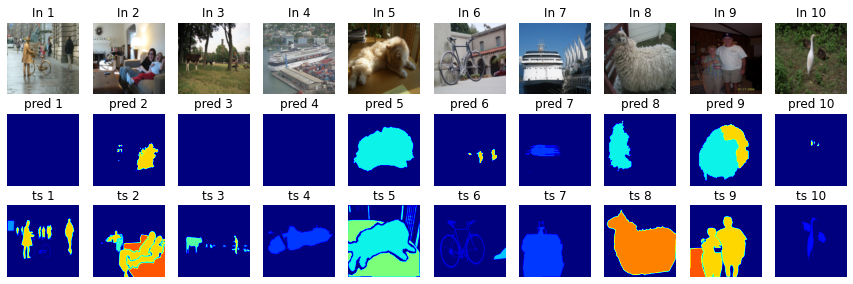

Iter:450, Loss:1.1219, Accuracy:0.5369
Iter:500, Loss:1.0084, Accuracy:0.5509
Iter:550, Loss:0.9524, Accuracy:0.5700
Iter:600, Loss:0.9192, Accuracy:0.5697
save  >> models/UNet_iter600.pt
result was saved to >> result/UNet_result_iter600.jpg


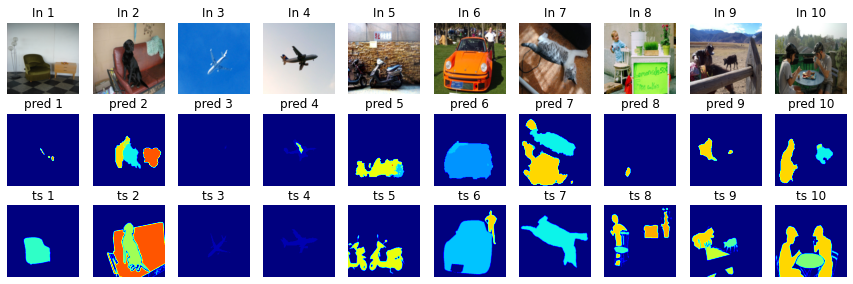

Iter:650, Loss:0.9719, Accuracy:0.5501
Iter:700, Loss:1.0616, Accuracy:0.5449
Iter:750, Loss:0.6041, Accuracy:0.6401
Iter:800, Loss:0.6672, Accuracy:0.6191
save  >> models/UNet_iter800.pt
result was saved to >> result/UNet_result_iter800.jpg


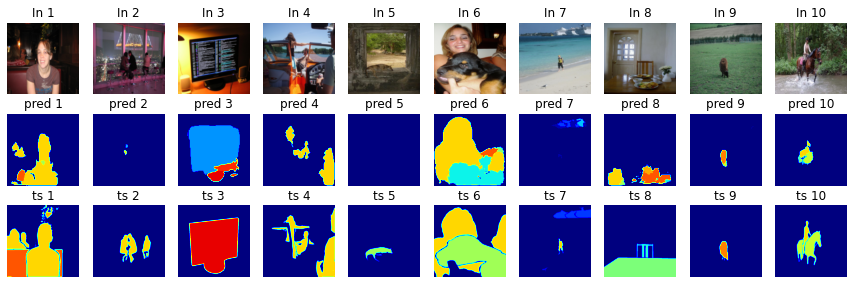

Iter:850, Loss:0.8266, Accuracy:0.5896
Iter:900, Loss:0.6805, Accuracy:0.6252
Iter:950, Loss:0.7139, Accuracy:0.6086
Iter:1000, Loss:0.5735, Accuracy:0.6402
save  >> models/UNet_iter1000.pt
result was saved to >> result/UNet_result_iter1000.jpg


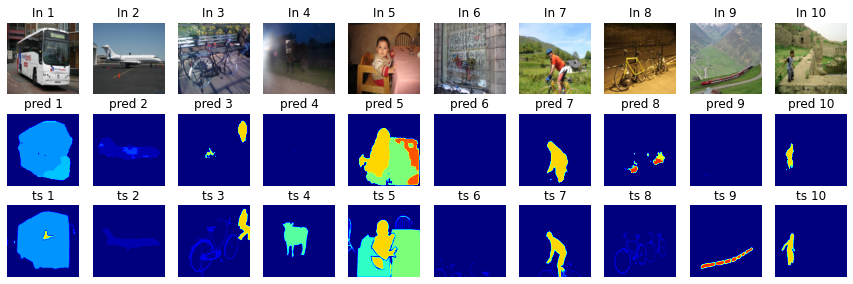

Iter:1050, Loss:0.5528, Accuracy:0.6524
Iter:1100, Loss:0.6106, Accuracy:0.6353
Iter:1150, Loss:0.4913, Accuracy:0.6525
Iter:1200, Loss:0.4867, Accuracy:0.6505
save  >> models/UNet_iter1200.pt
result was saved to >> result/UNet_result_iter1200.jpg


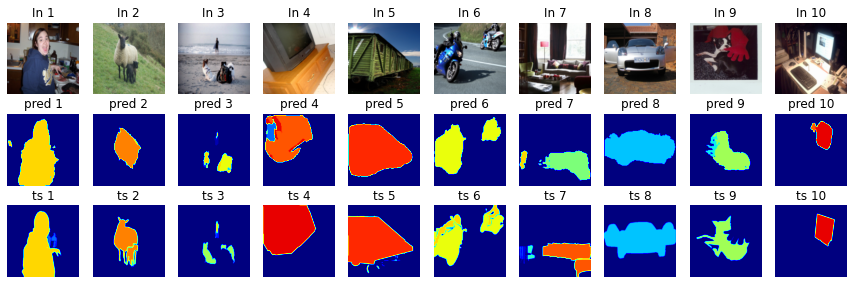

Iter:1250, Loss:0.3950, Accuracy:0.6804
Iter:1300, Loss:0.5802, Accuracy:0.6354
Iter:1350, Loss:0.4423, Accuracy:0.6660
Iter:1400, Loss:0.3147, Accuracy:0.6897
save  >> models/UNet_iter1400.pt
result was saved to >> result/UNet_result_iter1400.jpg


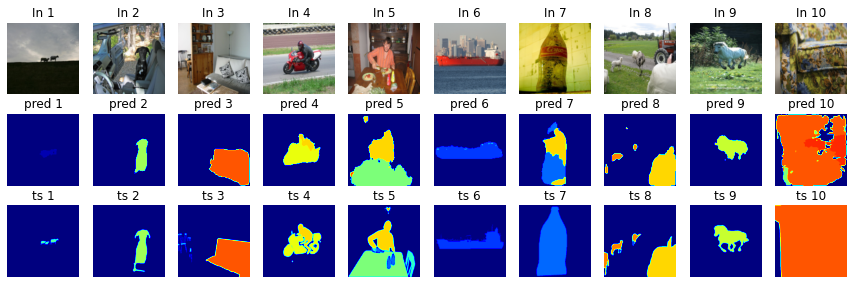

Iter:1450, Loss:0.4073, Accuracy:0.6660
Iter:1500, Loss:0.4446, Accuracy:0.6636
Iter:1550, Loss:0.3928, Accuracy:0.6722
Iter:1600, Loss:0.3017, Accuracy:0.6979
save  >> models/UNet_iter1600.pt
result was saved to >> result/UNet_result_iter1600.jpg


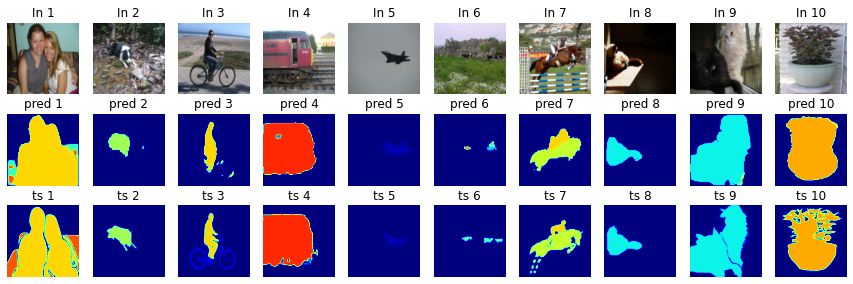

Iter:1650, Loss:0.3376, Accuracy:0.6885
Iter:1700, Loss:0.2806, Accuracy:0.6990
Iter:1750, Loss:0.3837, Accuracy:0.6820
Iter:1800, Loss:0.4233, Accuracy:0.6623
save  >> models/UNet_iter1800.pt
result was saved to >> result/UNet_result_iter1800.jpg


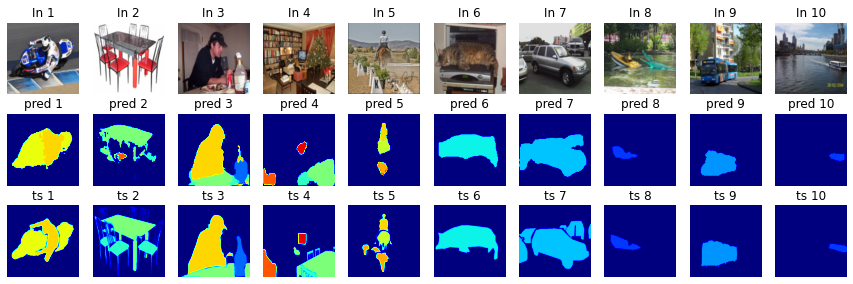

Iter:1850, Loss:0.3032, Accuracy:0.6936
Iter:1900, Loss:0.3260, Accuracy:0.6933
Iter:1950, Loss:0.2545, Accuracy:0.7034
Iter:2000, Loss:0.2958, Accuracy:0.6959
save  >> models/UNet_iter2000.pt
result was saved to >> result/UNet_result_iter2000.jpg


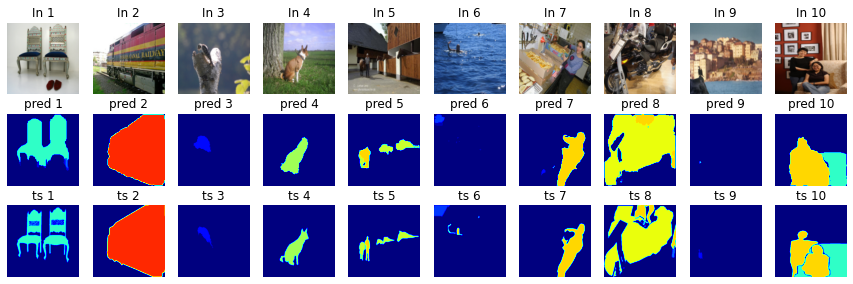

Iter:2050, Loss:0.2568, Accuracy:0.7058
Iter:2100, Loss:0.2974, Accuracy:0.6960
Iter:2150, Loss:0.3055, Accuracy:0.6903
Iter:2200, Loss:0.2618, Accuracy:0.7043
save  >> models/UNet_iter2200.pt
result was saved to >> result/UNet_result_iter2200.jpg


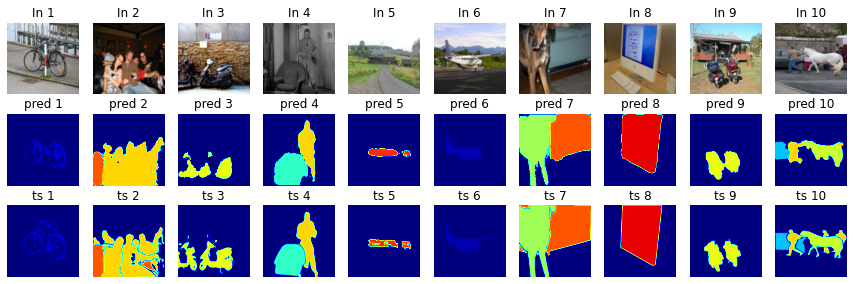

Iter:2250, Loss:0.2636, Accuracy:0.7038
Iter:2300, Loss:0.1900, Accuracy:0.7144
Iter:2350, Loss:0.2783, Accuracy:0.7011
Iter:2400, Loss:0.2958, Accuracy:0.6956
save  >> models/UNet_iter2400.pt
result was saved to >> result/UNet_result_iter2400.jpg


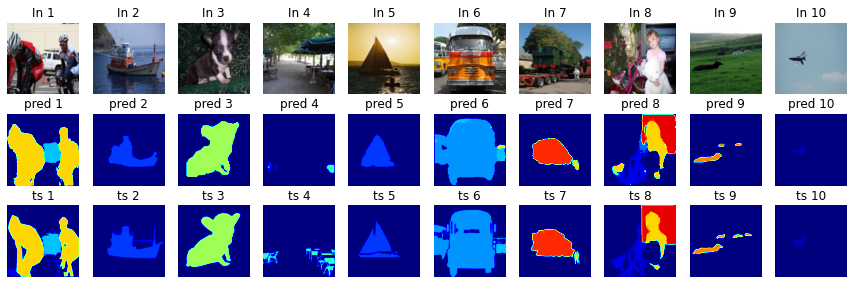

Iter:2450, Loss:0.2166, Accuracy:0.7102
Iter:2500, Loss:0.2389, Accuracy:0.7080
Iter:2550, Loss:0.2288, Accuracy:0.7089
Iter:2600, Loss:0.2199, Accuracy:0.7095
save  >> models/UNet_iter2600.pt
result was saved to >> result/UNet_result_iter2600.jpg


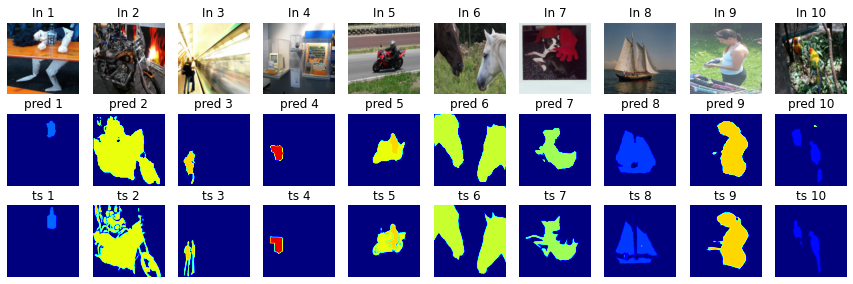

Iter:2650, Loss:0.2203, Accuracy:0.7091
Iter:2700, Loss:0.2518, Accuracy:0.7053
Iter:2750, Loss:0.2137, Accuracy:0.7107
Iter:2800, Loss:0.1686, Accuracy:0.7190
save  >> models/UNet_iter2800.pt
result was saved to >> result/UNet_result_iter2800.jpg


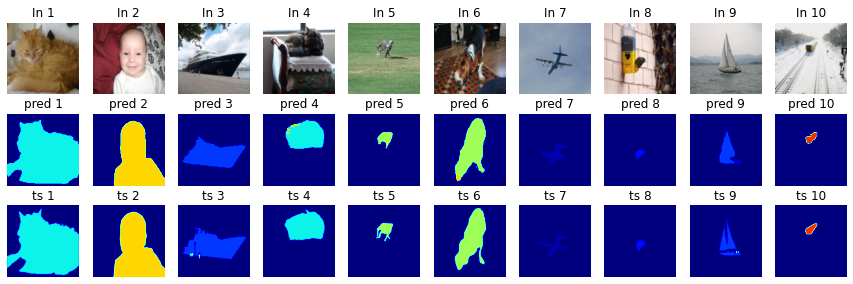

Iter:2850, Loss:0.2235, Accuracy:0.7076
Iter:2900, Loss:0.2646, Accuracy:0.6994
Iter:2950, Loss:0.2444, Accuracy:0.7030
Iter:3000, Loss:0.1729, Accuracy:0.7186
save  >> models/UNet_iter3000.pt
result was saved to >> result/UNet_result_iter3000.jpg


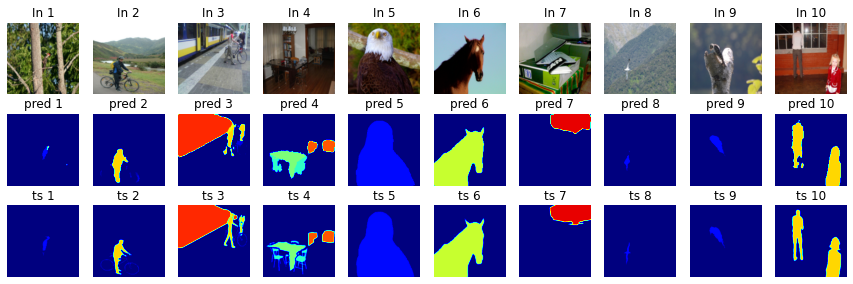

final paramters were saved to >> models/UNet_final.pt
loss was saved to >> result/UNet_loss.txt


In [37]:
# train
def train():
    # model
    model = UNet().to(cfg.DEVICE)
    summary(model, (cfg.INPUT_CHANNEL, cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH), device=cfg.DEVICE_TYPE)

    model.train()

    opt = cfg.TRAIN.OPTIMIZER(model.parameters(), **cfg.TRAIN.LEARNING_PARAMS)

    # path_dict = data_load(cfg, hf=cfg.TRAIN.DATA_HORIZONTAL_FLIP, vf=cfg.TRAIN.DATA_VERTICAL_FLIP, rot=cfg.TRAIN.DATA_ROTATION)
    # paths = path_dict['paths']
    # paths_gt = path_dict['paths_gt']

    ds = torchvision.datasets.VOCSegmentation(root=cfg.TRAIN.DATA_PATH, image_set='train', download=True, 
                                          transform=transform, target_transform=target_transform)

    data_num = len(ds)
    print('train data =', data_num)
    
    # training
    batch_gen = BatchGenerator(data_num, cfg.TRAIN.MINIBATCH)

    list_iter = []
    list_loss = []
    list_accuracy = []

    ones = torch.zeros([cfg.TRAIN.MINIBATCH, 1], dtype=torch.float).to(cfg.DEVICE)
    zeros = ones * 0
    
    loss_l1 = torch.nn.CrossEntropyLoss()

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        mb_inds = batch_gen()
        # sample X
        Xs = torch.cat([ds[xi][0].unsqueeze(0) for xi in mb_inds]).to(cfg.DEVICE)
        ts = torch.cat([ds[xi][1].unsqueeze(0) for xi in mb_inds]).to(cfg.DEVICE)
        # Xs = Xs_data[mb_inds].to(cfg.DEVICE)
        # ts = ts_data[mb_inds].to(cfg.DEVICE)

        # update G
        opt.zero_grad()

        ys = model(Xs)

        # reshape output and ts for loss
        _ys = ys.reshape(ys.size()[0], ys.size()[1], -1)
        _ts = ts.reshape(ts.size()[0], -1)

        loss = loss_l1(_ys, _ts) # L1 loss
        loss.backward()
        opt.step()

        preds = _ys.argmax(dim=1)
        accuracy = (preds == _ts).sum() / float(cfg.TRAIN.MINIBATCH * cfg.OUTPUT_HEIGHT * cfg.OUTPUT_WIDTH)


        progres_bar += '|'

        _loss = loss.item()
        _accuracy = accuracy.item()

        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss.append(_loss)
                list_accuracy.append(_accuracy)

        print('\r' + 'Loss:{:.4f}, Accu:{:.4f} '.format(_loss, _accuracy) + progres_bar, end='')
                
        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, Loss:{:.4f}, Accuracy:{:.4f}'.format(i + 1, _loss, _accuracy))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            save_path = cfg.TRAIN.MODEL_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(model.state_dict(), save_path)
            print('save  >> {}'.format(save_path))

        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            result_show(
                Xs, ys.argmax(dim=1), ts, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE, show=True, cmap_in=cfg.INPUT_CMAP, cmap_out=cfg.OUTPUT_CMAP)

    save_path = cfg.TRAIN.MODEL_SAVE_PATH.format('final')
    torch.save(model.state_dict(), save_path)
    print('final paramters were saved to >> {}'.format(save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss' : list_loss, 'accuracy' : list_accuracy})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

## plot Loss, Accuracy

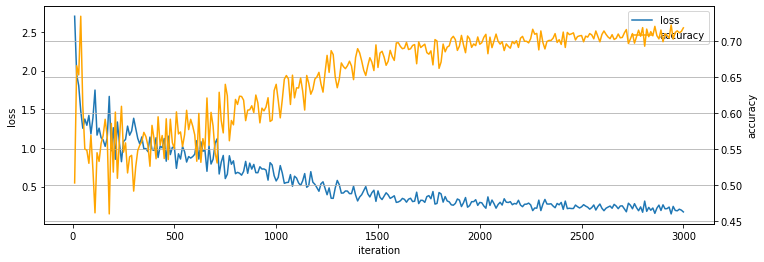

In [38]:
def plot_process():
    df = pd.read_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax2 = ax.twinx()
    lns1 = ax.plot(df['iteration'], df['loss'], label='loss')
    lns2 = ax2.plot(df['iteration'], df['accuracy'], color='orange', label='accuracy')

    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)
    ax.set_ylabel('loss')
    ax.set_xlabel('iteration')
    ax2.set_ylabel('accuracy')
    plt.grid()
    plt.show()

plot_process()

## Test

--------------------
test function
--------------------
Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
data = 1449


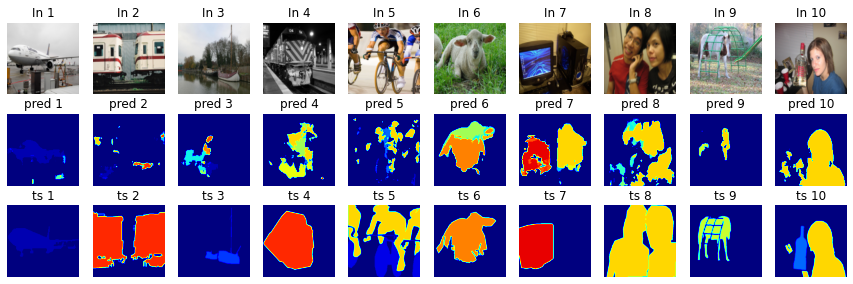

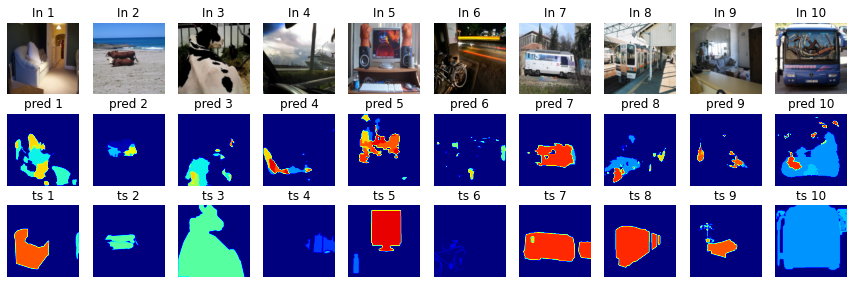

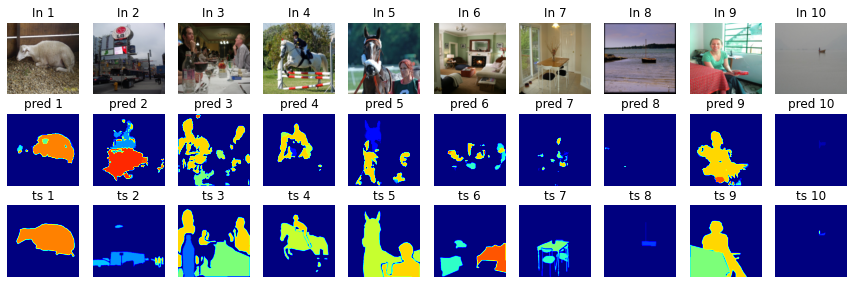

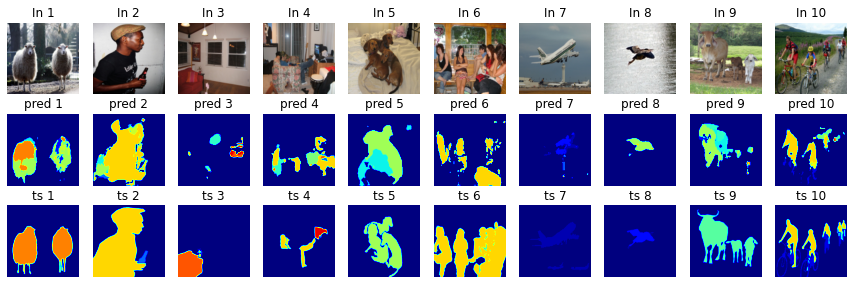

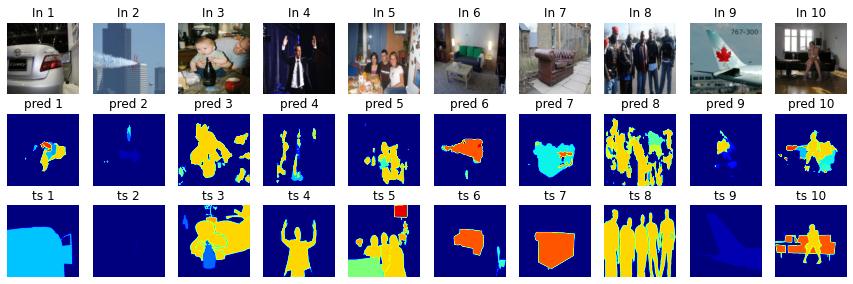

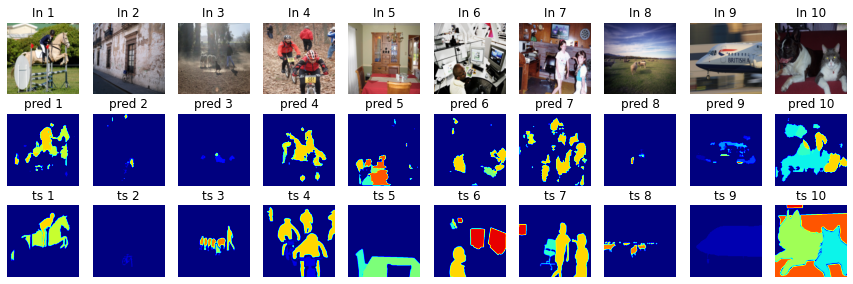

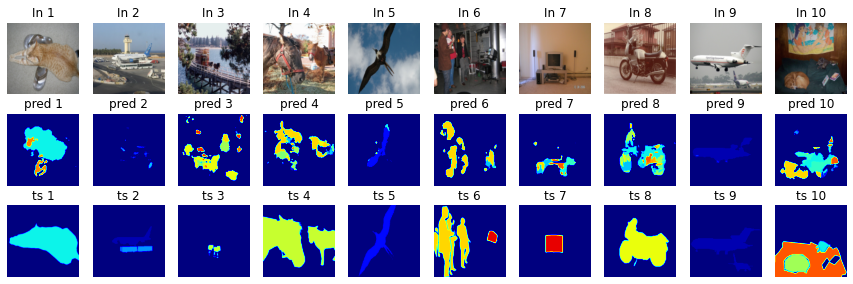

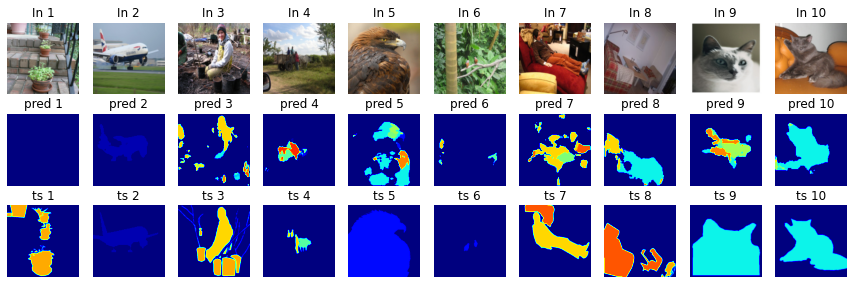

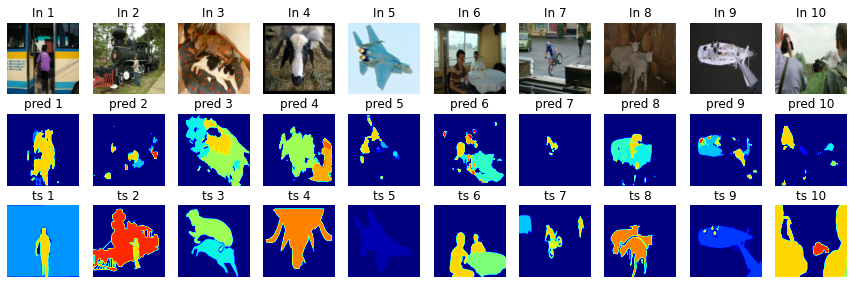

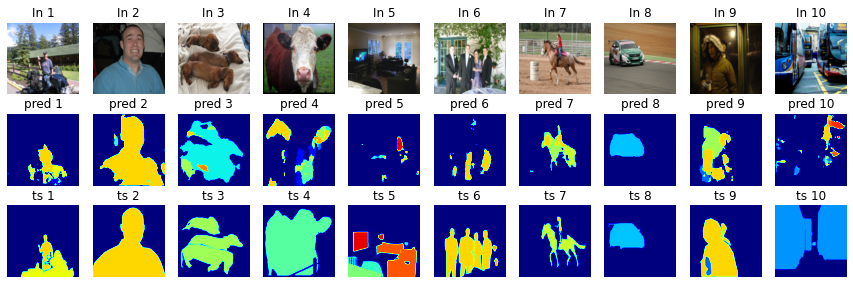

In [44]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    model = UNet().to(cfg.DEVICE)
    model.load_state_dict(torch.load(cfg.TEST.MODEL_PATH, map_location=torch.device(cfg.DEVICE)))
    model.eval()

    ds = torchvision.datasets.VOCSegmentation(root=cfg.TRAIN.DATA_PATH, image_set='val', download=True, 
                                          transform=transform, target_transform=target_transform)

    data_num = len(ds)
    print('data =', data_num)

    max_num = min(data_num, cfg.TEST.MAX_SAMPLES) if cfg.TEST.MAX_SAMPLES is not None else data_num

    with torch.no_grad():
        for i in range(0, max_num, cfg.TEST.MINIBATCH):
            mb_inds = np.arange(i, min(i + cfg.TEST.MINIBATCH, max_num))
            
            Xs = torch.cat([ds[xi][0].unsqueeze(0) for xi in mb_inds]).to(cfg.DEVICE)
            ts = torch.cat([ds[xi][1].unsqueeze(0) for xi in mb_inds]).to(cfg.DEVICE)
           
            ys = model(Xs) 

            result_show(Xs, ys.argmax(dim=1), ts, cfg.TEST.RESULT_IMAGE_PATH.format(i + 1), 
                        save=cfg.TEST.RESULT_SAVE, show=True, cmap_in=cfg.INPUT_CMAP, cmap_out=cfg.OUTPUT_CMAP)
test()

In [0]:
def arg_parse():
    parser = argparse.ArgumentParser(description='CNN implemented with Keras')
    parser.add_argument('--train', dest='train', action='store_true')
    parser.add_argument('--test', dest='test', action='store_true')
    args = parser.parse_args()
    return args

# main
if __name__ == '__main__':
    args = arg_parse()

    if args.train:
        train()
    if args.test:
        test()

    if not (args.train or args.test):
        print("please select train or test flag")
        print("train: python main.py --train")
        print("test:  python main.py --test")
        print("both:  python main.py --train --test")


## VOC Data load sample

In [0]:
transform = transforms.Compose([
    transforms.Resize((cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH)),
    transforms.ToTensor(),
])

ds = torchvision.datasets.VOCSegmentation(root=cfg.TRAIN.DATA_PATH, image_set='train', download=True, 
                                          transform=transform, target_transform=None)

In [0]:
Xs_data, ts_data = ds[0]

In [0]:
Xs_data

In [0]:
Xs_data.size()

In [0]:
ts_data

In [0]:
ts_data.size()

In [0]:
ts_data[ts_data != 0]

In [0]:
_ts = np.array(ts_data.convert('P'))

In [0]:
_ts.shape

In [0]:
_ts

In [0]:
_ts[_ts != 0]

In [0]:
np.unique(_ts, return_counts=True)

In [0]:
_ts[_ts == 255] = 0

In [0]:
plt.imshow(_ts, vmax=21)

In [0]:
for i in range(20):
    Xs, ts = ds[i]
    plt.subplot(1, 2, 1)
    plt.imshow(Xs.permute(1, 2, 0))
    plt.subplot(1, 2, 2)
    plt.imshow(ts[0], cmap='gray')
    plt.show()

### try my transform

In [0]:
from PIL import Image

class Seg2Index(object):
    def __init__(self, border=False):
        self.border = border # contain border

    def __call__(self, x):
        x = np.array(x.convert('P')) # convert image > index
        if not self.border:
            x[x == 255] = 0
        return Image.fromarray(x)

    def __repr__(self):
        return self.__class__.__name__ + '()'

class ToTensorKeepValue(object):
    def __call__(self, x):
        return torch.tensor(np.array(x))

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [0]:
transform = transforms.Compose([
    transforms.Resize((cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH)),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    Seg2Index(),
    transforms.Resize((cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH)),
    ToTensorKeepValue()
])

ds = torchvision.datasets.VOCSegmentation(root=cfg.TRAIN.DATA_PATH, image_set='train', download=True, 
                                          transform=transform, target_transform=target_transform)

In [0]:
for i in range(20):
    Xs, ts = ds[i]
    plt.subplot(1, 2, 1)
    plt.imshow(Xs.permute(1, 2, 0))
    plt.subplot(1, 2, 2)
    plt.imshow(ts, vmax=22, cmap='jet')
    print(ts.size(), ts.max())
    plt.show()

In [0]:
ds

In [0]:
len(ds)

In [0]:
torch.cat([ds[xi][0].unsqueeze(0) for xi in [0,3,4]]).to(cfg.DEVICE).size()

In [0]:
[ds[xi][0] for xi in [0,3,4]]

In [0]:
ds[0][0].